# The Pytorch Implementation of InfoGAN
Pytorch를 사용하여 InfoGAN을 구현하여 MNIST 이미지 생성을 개선합니다.
### Reference
* Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets(https://arxiv.org/abs/1606.03657)
* Professor Moon's Implicit DGM lecture material 

### Package Installation
학습에 필요한 패키지들(torch, torchvision, pillow, urllib3, scikit-image, scipy, numpy, matplotlib) 등을 설치합니다.  
<code>pip install -r requirements.txt</code>

### Issue on Downloading the MNIST dataset
* 아래의 코드는 제공된 url을 통해서 MNIST dataset을 다운로드할 수 있도록 제공하고 있습니다. 하지만, 종종 url을 통한 데이터 다운로드에 오류가 발생할 수 있고, 이 경우에는https://drive.google.com/drive/folders/1SzwS6lLjeAXYkCjPou8AWFxSLnHW4sMS?usp=sharing
에서 MNIST 폴더를 다운로드 받은 후 바로 아래의 cell을 한번 실행한 후 생성된 data/mnist 폴더에 다운받은 폴더를 옮긴 다음 진행하면 됩니다.  

In [ ]:
# 패키지 다운로드가 필요한 경우
# pip install -r requirements.txt   #  '#' 지우고 해당 셀 실행

In [2]:
# 학습에 사용하는 모듈을 import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.optim as optim

import numpy as np
import datetime
import os, sys
import math
import matplotlib.pyplot as plt

os.makedirs("data/mnist", exist_ok=True)  # data/mnist directory 생성

# (Theoretical Backgorund)
Generative Adversarial Network(GAN) 은 generator와 discrimintor 두 모델이 서로 경쟁하듯 학습(adversarial learning)되어 동시에 서로의 성능이 올라가는 게임 이론에 근본을 둔 생성 모델입니다. Generator와 discriminator에 convolutional neural network 를 사용하여 adversarial learning을 하는 모델을 Deep Convolutional Generative Adversarial Network(DCGAN)이라고 합니다.   

Generator는 input 공간의 Gaussian noise $z$를 통해서 image를 생성하며 adversarial learning을 통해서 image의 유의미한 특징(MNIST dataset을 예로 들면 글자의 digit 정보, style 정보, 기울기 정보등이 될수 있으며 이를 $\color{blue}{\text{code}}$ 라고 부릅니다.)을 추출할 수 있습니다. 또한 유의미한 특징의 $\color{blue}{\text{의미}}$를 잘 이해한 모델의 경우는 약간씩 변화를 줄 경우, 그 변화에 맞춰서 부드럽게 변화 해야 합니다. 아래 그림에서 (a)는 InfoGAN, (b)는 vanilla GAN 에서 0~9 각각의 digit type을 나누는 categorical code($c_1$)를 약간씩 변화를 주었을 때의 결과로, vanilla GAN은 별다른 의미를 찾기 어려운 반면, InfoGAN은 $c_1$을 잘 학습하며 이에대한 의미를 잘 이해하여 code에 맞는 image를 생성합니다.
<img src="gan_images/code.png">  

이 Tutorial 에서는 유의미한 특징을 좀 더 잘 뽑아낼 수 있고, 이에 대한 의미를 잘 이해할 수 있는 InfoGAN을 다뤄보도록 합니다.


## Mutual Information for Inducing Latent Codes

Vanilla GAN은 아래와 같은 손실함수를 최적화하도록 설계되어 있습니다.
### $$\min_G\max_D L(G,D) = \mathbb{E}_{x \sim p_r} [log D(x)] + \mathbb{E}_{z \sim p_z}[log(1-D(G(z))) ] $$
- $p_z$ : noise input의 분포 || $p_g$ : data $x$에 대한 generator의 분포 || $p_r$ : 실제 샘플 $x$에 대한 데이터 분포

### **(Disentangled representation)**
여기서 z의 individual dimensions은 데이터의 어떤 주요한 의미와 대응되어 있지 않습니다. 이러한 latent space에서 의미를 파악하기 어려운 representation을 매우 꼬인($\color{red}{\text{highly entangled}}$) representation 이라고 합니다. 반대로 대부분의 데이터는 사람이 보기에 의미적으로 중요한(semantically important) 특징들로 표현할 수 있습니다. 앞서 예로 든 MNIST data는 digit 정보, style 정보, 기울기 정보 등이 유의미한 특징들을 가집니다( 이러한 특징들을 $\color{red}{\text{disentangled}}$ representation 이라고 합니다).

아래 그림은 왼쪽이 entangled representation, 오른쪽이 disentangled representation을 의미합니다. Disentangled representation은 latent space의 basis dimension이 의미를 가지고 해석하기가 편해집니다. MNIST data를 예로들면, y축 방향으로 움직이는 것은 category가 바뀌는 것을 x축 방향으로 움직이는 것은 어떤 continuous한 유의미한 특징인 기울기나 글짜의 너비 등이 바뀐다고 생각해볼 수 있습니다.
<img src="gan_images/disentangle.png">  
Data의 dimension이 커질수록 이런 해석가능한 특징들을 학습하기 어렵기 때문에 unsupervised learning을 통해서 entgnaled representation을 disentangle 하게 바꿀 수 있는 과정이 필요하게 됩니다. 

### **(Mutual Information)**  
InfoGAN은 생성 모델이 representation을 학습할 때 약간의 제약을 주어, 보다 풀린(disentagled) 방식으로 representation을 학습하도록 도와줍니다. 따라서 generator의 input에 Gaussian nosie에 해당하는 $z$ 와 유의미한 특징에 해당하는 latent code $c$를 넣습니다. 어떻게 하면 생성 모델이 latent code인 $c$의 의미를 학습할 수 있을까요? 이를 설명하기 위해서 정보 이론에서 정의한 상호 정보량(Mutual Information)을 도입합니다.  

* $\color{blue}{\text{Mutual Information }} I(X;Z)$ 는 $X$에서 $Z$로 설명될 수 있는 정보량을 의미하며 수식은 다음과 같습니다.  
### $$ I(X;Z) := D_{KL}(p(x,z) || p(x)p(z)) = H(X)-H(X|Z) = H(Z)-H(Z|X) $$
정의로부터 joint distribution 와 marginal distribution의 곱의 차이를 측정하며 이는 두 random variable의 dependency를 측정하는것과 같습니다. 만약 independent 한 경우에는 $D_{KL}$ 값이 0이 되며, dependency가 강해질수록 값이 커지게 됩니다. 그리고 cross entropy와의 관계식을 통해서 $Z$가 관측되었을 때 $X$에서 사라지는 불확실성(uncertainty)로도 해석이 가능합니다.  

- Vanilla GAN 에서는 생성 모델이 $G(z,c)$가 되어도 $p_g(x|z,c) = p_g(x|z)$ 인 solution을 찾는 방향으로 학습하여 $c$에 대한 정보를 활용하지 않습니다. 즉 $I(c;G(z,c)) \approx 0 $ 인 상태로 학습이 진행되고 있음을 알 수 있습니다.  

- InfoGAN 에서는 생성 모델이 c의 정보를 잘 활용하게 학습하기를 원합니다. 즉 $I(c;G(z,c))$ 를 높이도록 학습하는 것을 원합니다. 이를 loss function에 regularize term으로 추가해줍니다.  
### $$\min_G\max_D L_I(G,D) =  L(G,D) - \lambda I(c;G(z,c)) $$
Regularizer를 '-' term으로 넣으면 minimization 문제를 풀게될때 자동적으로 $I(c;G(z,c))$ 를 최대화 하는 방향으로 훈련을 진행합니다.

이로써 우리는 GAN에 image를 생성할때 code에 대한 conditionally dependent한 아래와 같은 latent model을 만들수 있었습니다.(GAN + Latent Model)
<img src="gan_images/Bayesian.png">  

## Variational Mutual Information Maximization

$I(c;G(z,c))=H(c)-H(c| G(z,c))$ 를 계산하기 위해서는 
- $H(c)= -\int_c p(c)log p(c) dc $ 를 계산하기 위해서는 prior distribution $p(c)$를 알아야하고, 
- \begin{align} H(c|G(z,c)=x) = \iint_{c,x} p(x,c) log p(c|x) dcdx &= \iint_{c,x} p(x)p(c|x) log p(c|x) dxdc \\   &= \mathbb{E}_{x \sim p_g} [\mathbb{E}_{c' \sim p(c|x)}[ log p(c'|x) ]  ] \end{align} 를 계산하기 위해서는 posterior $p(c|x)$, generator distribution $p_g(x)$를 계산할수 있어야합니다. 

하지만 $p(c|x)$가 계산이 불가능($\color{red}{\text{intractable}}$) 하기 때문에(관측된 image $x$를 가장 잘 표현할 수 있는 $c$를 알면 학습이 의미가 없게된다.), variational distribution $q$ 를 두어 $p(c|x)$를 직접적으로 이용하는 것은 피했다.
\begin{align}I(c;G(z,c)) &= H(c)-H(c|G(z,c)) \\ &= H(c) + \mathbb{E}_{x \sim p_g} [\mathbb{E}_{c' \sim p(c | x)} [log p(c'|x)]] \\ &= H(c) + \mathbb{E}_{x \sim p_g}[ \mathbb{E}_{c' \sim p(c'|x )} [log( \frac{p(c'|x)}{q(c'|x)} q(c'|x) )] ]  \\ &= H(c) + \mathbb{E}_{x \sim p_g}[D_{KL} (p(\cdot|x) || q(\cdot|x)) + \mathbb{E}_{c' \sim p(c|x)} [  logq(c'|x) ]]   \\ &\geq H(c)+\mathbb{E}_{x \sim p_g} [\mathbb{E}_{ \color{red}{ c' \sim p(c|x) }} [log q(c'|x) ]   ]  \enspace  (\because D_{KL} \geq 0) \\ &= H(c)+\mathbb{E}_{\color{blue}{c \sim p(c)}, x \sim p_g(x)} [logq(c|x)] := L_{LI}(G,q) \end{align}
 
값을 구하기 힘든 식의 계산을 lower bound를 이용해 해결하는 모습을 볼 수 있었고, 이를 '$\color{blue}{\text{Variational Mutual Information Maximization}} $' 라고 합니다.   

마지막 줄의 eqaulity 는 $\mathbb{E}_{ \color{blue}{x \sim X}, y \sim Y|x} [f(x,y)] = \mathbb{E}_{x \sim X, y \sim Y|x, \color{red}{x' \sim X|y}}[f(x',y)]$ 를 사용 하였습니다.

$c$를 데이터 $x$에 상관없이 샘플링 해서 계산해도 원하는대로 학습이 된다는것을 확인할 수 있습니다. 마지막으로 $ -I(c;G(z,c)) \leq -L_{LI}(G,q) $ 를 적용해서 구하고자 하는 loss function의 upper bound 에 대한 최적화 문제인 
 ### $$\min_G\max_D L_{InfoGAN}(G,q,D) :=  L(G,D) - \lambda L_{LI}(G,q) $$
 가 됩니다.

## cGAN vs InfoGAN

두 GAN model 모두 주어진 condition에 맞는 image를 생성하는 것을 목표로 하고 있습니다. 다만 큰 차이점은
* cGAN 의 경우 $c$ 가 $\color{red}{\text{supervised label}}$로 주어져있는 경우이며, discriminator 역시 condition이 주어졌을때의 fake/real을 구별하는 역할을 하게 됩니다. 모델의 대략적인 구조는 아래와 같습니다.  
<img src="gan_images/cGAN.png">  

* InfoGAN의 경우 $c$ 가 $\color{red}{\text{not supervised label}}$인 latent variable로 주어져있으며, discriminator는 condition을 input으로 받지 않고, q(auxiliary distribution) 을 이용해서 원하는 의미의 특징을 학습합니다. 모델의 대략적인 구조는 아래와 같습니다.  
<img src="gan_images/InfoGAN.png">

# (Implementaion Part)
이 tutorial 에서는 InfoGAN 을 활용하여 행으로는 categorial code 인 digit 특성에 따른 image, 열로는 continuous code 인 rotation(width)에 따른 image 들을 모아놓은 MNIST image grid를 생성할 것입니다. 


학습에 사용되는 파라미터를 설정해줘야 합니다.  
Code 와 generated image간의  Mutual Information 에 대한 regularizer parameter를 고려해서 학습을 하되, continuous code 에 대한 regularizer parameter를 상대적으로 작게 설정합니다. 이는 continuous code의 variance의 영향력이 커지면 특정 Mode에 대한 drop 현상이 발견되기 때문입니다.

In [15]:
# 파라미터 설정
device = torch.device('cuda' if torch.cuda.is_available else 'cpu') # gpu 지원 여부에 따라 어떤 device를 사용할 지 결정

# Hyperparameter 설정

#dataset param
batch_size = 64 # training data 를 작은 그룹(mini batch)로 나누었을 때 속하는 data 수


# Set appropriate hyperparameters depending on the dataset used.

# generator input dimension : these values given in the InfoGAN paper are used
num_z = 62 # latent space 중 noise 의 dimension
num_dis_c = 1 # discrete latent code 사용 개수
dis_c_dim = 10 # discrete latent code 의 dimension
num_con_c = 2 # continuous latent code 사용 개수 (dimension 은 각각 '1')

# optimizer hyper-parameter
lr = 0.0002 # Learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of second order momentum of gradient
num_epochs = 200 # 학습 총 epoch 수
save_epoch = 25 #  How many epochs to save checkpoins and generate test output

# regularizer parameter for mutual information
reg_disc = 1.0
reg_conti = 0.1


## Architeture based on InfoGAN paper   
* The generator is the same as the existing DCGAN architecture. However, in this paper, the latent input consists of a noise vector(62), discrete code(10), and continuous code(2).
<img src="gan_images/Generator.png">  

* The discriminator also has the same basic structure as the existing DCGAN structure.  
  - DHead acts as a existing discriminator to determine whether a generated image is real or fake.
  - QHead generates discrete and continuous ocdes that can increase mutual information through fake images.

<img src="gan_images/Discriminator.png">  

# Condition of code to be generated
* Categorical code는 모아서 softmax해주면 되고 continuous code는 factored(단순히 곱했다는 뜻이다; 각 차원의 원소들이 모두 독립) Gaussian으로 생각하고 구현해도 충분하다고 한다.

* Objective function은 softmax해준 결과와 
Q-network의 output과 cross-entropy를 취해 구하면 됩니다. 
(Logit은 sigmoid나 softmax가 씌워지기 전의 값을 의미합니다.)  

* Continuous한 변수의 분포를 추정하는 기존의 머신러닝 방법 중에 gaussian log likelihood라는 방법이 있는데, 목표 분포가 그냥 gaussian 이라고 가정하고 mean, std를 추정하는 방법이다. 그러면 $P(c|x)$를 gaussian 이라고 가정하고 Q_logits가 $\hat{c} = \mu_{c|x}, \sigma = \sigma_{c|x}$ 를 뱉는것으로 모델링 할 수 있다. MLE 방법으로 $p(c| \hat{c}, \sigma^2)$가 최대가 되도록 학습하면 됩니다.

1. $\sigma$ 가 상수인경우 $min_{\hat{c}} MSE$와 동치
$$ \min_{\hat{c}}l = -log p(c|\hat{c},\sigma^2) = \frac{1}{2\sigma^2} \|c-\hat{c}\|^2 + \frac{N}{2} log \sigma^2 + \frac{N}{2} log( 2 \pi)$$
2. $\sigma$ 를 학습하는 형태인경우
$$ \min_{\hat{c},\sigma^2} l= -log p(c|\hat{c},\sigma^2) = \sum_{i=1}^N \{log \sigma_i + \frac{(c_i-\hat{c}_i)^2}{2\sigma_i^2} \} + \frac{N}{2} log( 2 \pi) $$

In [4]:
class Generator(nn.Module):
     # nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias) : Upsampling 을 통한 차원확장
     # dim : (batch_size, in_channel,in_height, in_width) -> (batch_size, out_channel, out_height, out_width)
     #       out_height = (in_height-1)* stride -2 *padding + kernel_size 
     #       out_width = (in_width-1)* stride -2 *padding + kernel_size
    """
        Convolutional Generator for MNIST
        *Input
            -input_size : dimension of latent space (gaussian noise)
            -code_size : 1 ten-dimensional categorical code + 2 continuous latent codes
        *output
            -batch_sizex1x28x28 MNIST images 
    """
    def __init__(self, input_size = num_z, code_size = dis_c_dim + num_con_c):  # code_size = 10 + 2 = 12
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
         # 1st layer dim : (batch_size, input_size + code_size= 74, 1, 1) -> (batch_size, 1024 , 1 ,1)                           
            nn.ConvTranspose2d(input_size+code_size, 1024, 1, 1, 0,  bias = False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            
        # 2nd layer dim : (batch_size, 1024, 1, 1) -> (batch_size, 128, 7, 7)
            nn.ConvTranspose2d(1024, 128, 7, 1, 0, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

        # 3rd layer dim : (batch_size, 128, 7, 7) -> (batch_size, 64, 14, 14)
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        
        # 4th layer dim : (batch_sizee, 64, 14, 14) -> (batch_size, 1, 28, 28)
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias = False),
            nn.Tanh(),
        )
        
    def forward(self, input): # input dim : (batch_size, 62+12, 1, 1)
        output = self.model(input)  # output dim : (batch_szie, 1, 28, 28)
        return output

In [5]:
class Discriminator(nn.Module):
    # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias) : Downsampling을 통한 차원축소 및 만들어진 data의 True/False를 output으로 만듬 
    # dim : (batch_size, in_channel,in_height, in_width) -> (batch_size, out_channel, out_height, out_width)
    #       out_height = (in_height+ 2* padding -kernel_size)/ stride 
    #       out_width = (in_width+ 2* padding -kernel_size)/ stride
    """
        Convolutional Discriminator for MNIST
        *Input
            -in_channel : color channel (default=1 for MNIST)
        *output
            - a vector(1024,1,1) before reaching the two heads
              (one head distinguishes whether an image is real or fake and
               the other head generates codes from the image )
    """
    def __init__(self, in_channel = 1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
        # 1st layer dim : (batch_size, 1, 28, 28) -> (batch_size, 64 , 14 ,14)
            nn.Conv2d(in_channel, 64, 4, 2, 1,  bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace = True),
            
         # 2st layer dim : (batch_size, 64, 14, 14) -> (batch_size, 128 , 7 ,7)   
            nn.Conv2d(64, 128, 4 , 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace = True),
        
         # 3rd layer dim : (batch_size, 128, 7, 7) -> (batch_size, 1024, 1, 1)
            nn.Conv2d(128, 1024, 7, 1, 0, bias =False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace = True),
        )
    def forward(self, input):
        output = self.model(input)
        return output
        

In [6]:
class DHead(nn.Module):
    # image가 진짜인지 가짜인지에 대한 점수를 [0,1] 사이로 매긴다.
    def __init__(self):
        super(DHead, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1024, 1, 1, 1, 0, bias = False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        output = self.model(input)
        return output

In [7]:
class QHead(nn.Module):
    """
        Regularization Network for increasing Mutual Information
        *Input
            - an image passed through discriminator
        *output
            - categorical code : logit value([0,1] 로 normalize 해서 확률값으로 만들어주는 softmax 이전의 값)
            - continuous code ; mu, exp(var) of rotation & thickness
    """
    def __init__(self):
        super(QHead, self).__init__()
        self.layer = nn.Sequential(

        # dim : (batch_size, 1024, 1, 1) -> (batch_size, 128, 1, 1) 
            nn.Conv2d(1024, 128, 1, 1, 0, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace = True),
                               
        )
        # Seperate Code
        # dim : (batch_size, 128, 1, 1) -> (batch_size, output_dim, 1, 1) 
        self.conv_disc = nn.Conv2d(128, 10, 1, 1, 0 , bias = False)
        self.conv_mu = nn.Conv2d(128, 2, 1, 1 ,0 ,bias = False)
        self.conv_var = nn.Conv2d(128 , 2 ,1 ,1 ,0, bias = False)

    def forward(self, input):
        input = self.layer(input)
        
        
        code_disc_logits = self.conv_disc(input).squeeze() # make the logit vector (softmax를 통과하면 digit 을 의미하는 code가 된다.)
        # dim : (batch_size, 10)
        code_mu = self.conv_mu(input).squeeze()  # dim : (batch_size, 2)
        code_var = torch.exp(self.conv_var(input).squeeze()) # dim : (batch_size, 2)
        
        return code_disc_logits, code_mu, code_var

## Data Preprocessing

* 본 코드에서는 Generator와 Critic을 훈련하기 위해 MNIST dataset을 사용할것입니다.
* MNIST 데이터는 1x28x28 (channel, width, height) 차원의 데이터입니다. Training data는 60000개, Test data는 10000개가 있습니다.
* 이미지의 경우 픽셀 값 하나는 0~255 값을 갖습니다. 데이터의 분포를 고르게 해주어 gradient descent 과정이 안정적이고 원활하게 일어나도록 유도합니다.

In [8]:
# Data augmentation 
transform = transforms.Compose([transforms.ToTensor(),  # data의 type을 Tensor로 변경
                                transforms.Normalize(mean = (0.5,), std=(0.5, ) )]) #  [-1,1] 사이의 값으로 normalized 시킨다. 
# Data Loading
dataloader = DataLoader(
    datasets.MNIST(
     root = "data/mnist", # 경로 지정
     train = True,        # train data를 받아옴. (False 면 test data를 받아옴)
     download = False,    # dataset이 없는 경우 True, (다운로드가 안되는경우, False로 설정 후 가장 위를 참조)
     transform = transform),
     batch_size = batch_size,
     shuffle = True,     # Epoch 마다 데이터가 학습되는 순서를 바꿈
    )


## Utils
1. Weights_Initialization : layer들의 초기 가중치가 0이면 모든 뉴런이 똑같이 업데이트 되는 문제가 발생 -> random number로 초기화합니다.
2. Normal_Negative_Log_Likelihood_Loss : $x = $Generated image, $P(c|x)$를 gaussian 이라고 가정하고 각 차원의 원소를 독립(disentangle)이라고 가정하고 negative log likelihood를 계산합니다.
3. Noise_Sample : latent space로 부터 (batch_size, input_dim = noise_dim + categorical_dim + continuous_dim) 차원을 가지는 sample을 뽑습니다. 
   - $z \sim N(0, I_{62})$, $c_1 \sim Cat(10)$, $c_2,c_3 \sim Unif[-1,1]$

In [9]:
def weights_init(m):
    """
    Initialize weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class NormalNLLLoss:
    """
    Calculate the negative log likelihood of normal distribution.
    Treating Q(cj | x) as a factored Gaussian.
    """
    def __call__(self, x, mu, var):
        
        logli = -0.5 * (2 * np.pi * var + 1e-6).log() - (x - mu)**2./(2.0 * var + 1e-6)
        nll = -(logli.sum(1).mean())

        return nll

In [11]:
def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
    """
    Sample random noise vector for training.
    INPUT
    --------
    n_dis_c : Number of discrete latent code.
    dis_c_dim : Dimension of discrete latent code.
    n_con_c : Number of continuous latent code.
    n_z : Dimension of iicompressible noise.
    batch_size : Batch Size
    device : GPU/CPU
    """

    z = torch.randn(batch_size, n_z, 1, 1, device=device)  # dim : (B,62,1,1)

    idx = np.zeros((n_dis_c, batch_size))
    if(n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)
        
        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0   

        dis_c = dis_c.view(batch_size, -1, 1, 1)  # dim : (B, 20, 1, 1)

    if(n_con_c != 0):
        # unif[-1,1]로 변환, #(B,2,1,1)
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    if(n_dis_c != 0):
        noise = torch.cat((z, dis_c), dim=1)
    if(n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1)

    return noise, idx

## InfoGAN Training  
우리의 훈련 loss function은 기존의 GAN의 loss에 generated image와 interpolate 하고자 하는 code간의 mutual information을 maximize 하는 weight들을 구하는 것입니다.
### $$ \min_{G,q}\max_D L_{InfoGAN}(G,q,D) :=  L(G,D) - \lambda L_{LI}(G,q) $$
- Discriminator를 update 할때에는 기존과 같은 loss를 사용합니다.
\begin{align} \min_{w_d}Loss_{Discriminator}(w_d) &= BCE(1,D(x;w_d))+BCE(0,D(G(z;w_g);w_d), x \sim p_r, z \sim p_z \\ (&= \max_{w_d} \mathbb{E}_{x \sim p_r}[logD(x;w_d)] + \mathbb{E}_{z \sim p_z} [log(1-D(G(z;w_g);w_d)]) \end{align}  

- Generator를 update 할때에는 위에서 설명한 것처럼 3가지 loss를 사용합니다.
    1. Original Generator : $BCE(1,G(z:w_g);w_d), z \sim p_z$ 
    2. Discrete Code : $CrossEntropy(logit_Q, target)(w_q) = - logit_Q[target] +\log \sum_{c=0}^{9} \exp(logit_Q[c]))$
    3. Continuous Code : $NLL_{Normal}(code=c ,\mu_q=\hat{c},\sigma_q=\sigma) (w_q) = -log p(c|\hat{c},\sigma^2) = \sum_{i=1}^N \{log \sigma_i + \frac{(c_i-\hat{c}_i)^2}{2\sigma_i^2} \} + \frac{N}{2} log( 2 \pi)  $  
   
\begin{align} \min_{w_g,w_q}Loss_{Generator}(w_g,w_q) &= BCE(1,D(G(z;w_g);w_d) - \lambda(CrossEntropy(w_q) + \lambda_{conti} * LogLikelihood_{Normal}(w_q)) \\ (&= \min_{w_g,w_q} BCE(1,D(G(z;w_g);w_q) + \lambda(logit_Q[target] \\ &- \log \sum_{c=0}^{9} \exp(logit_Q[c])) + \lambda_{conti} *  (\sum_{i=1}^2 \{log \sigma_i + \frac{(c_i-\hat{c}_i)^2}{2\sigma_i^2} \} + log( 2 \pi))    ) \end{align} 

- InfoGAN_MNIST.gif 를 열면 Epoch에 따라 MNIST image가 어떻게 향상되는지를 animation으로 확인할 수 있습니다.

In [13]:
import torchvision.utils as vutils
import matplotlib.animation as animation
import time
import random

# Set random seed for reproducibility.
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

# Use GPU if available.
print(device, " will be used.\n")

# Plot the training images.
sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 64], nrow=8, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.savefig('Training Images {}'.format('MNIST'))
plt.close('all')

# Initialise the network.
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

netD = DHead().to(device)
netD.apply(weights_init)
print(netD)

netQ = QHead().to(device)
netQ.apply(weights_init)
print(netQ)

# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()

# Adam optimiser is used.
D_params = list(discriminator.parameters()) + list(netD.parameters())
G_params = list(netG.parameters()) + list(netQ.parameters())
optimD = optim.Adam(D_params, lr= lr, betas=(b1, b2))
optimG = optim.Adam(G_params, lr= lr , betas=(b1, b2))

Random Seed:  1123
cuda  will be used.

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(74, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyR

In [27]:
real_label = 1
fake_label = 0

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []


# Fixed Noise : 
fixed_noise, _ = noise_sample(num_dis_c, dis_c_dim, num_con_c, num_z, batch_size, device)

# Data Type
data_type =  torch.float32
print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nDataset: {}\nBatch Size: %d\nLength of Data Loader: %d'.format('MNIST') % (num_epochs , batch_size, len(dataloader)))
print("-"*25)

start_time = time.time()
iters = 0

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    for i, (data, _) in enumerate(dataloader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device) # tensor([1]*batch_size)
        label = torch.as_tensor(label, dtype = data_type) # int -> float type
        output1 = discriminator(real_data)
        probs_real = netD(output1).view(-1)
        loss_real = criterionD(probs_real, label) # BCE(1, D(x))
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        label.fill_(fake_label) # tensor([0]*batch_size)
        noise, idx = noise_sample(num_dis_c, dis_c_dim, num_con_c, num_z, b_size, device)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach()) # not gradient update when generating output2
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label) #BCE(0, D(G(x)))
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator : #BCE(1,D(x)) + BCE(0, D(G(x)))
        D_loss = loss_real + loss_fake
        # Update parameters
        optimD.step()

        # Updating Generator and QHead
        optimG.zero_grad()

        # Fake data treated as real.
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label) # BCE(1, D(G(x)))

        q_logits, q_mu, q_var = netQ(output)
        target = torch.LongTensor(idx).to(device)
        # Calculating loss for discrete latent code.
        dis_loss = 0
        for j in range(num_dis_c):
            dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j]) # CrossEntropy

        # Calculating loss for continuous latent code.
        con_loss = 0
        if (num_con_c != 0): 
            con_loss = criterionQ_con(noise[:,num_z+num_dis_c*dis_c_dim :].view(-1, num_con_c), q_mu, q_var)  
            # Negative LogLikelihood with normal
            # q_var 에 의한 영향이 너무 커지면 특정 mode가 생성이 잘 안되는 현상이 발생 -> 작은 값을 곱해줍니다.
            
        # Net loss for generator = BCE(1, D(G(x))) + Mutual Info loss
        G_loss = gen_loss + reg_disc * dis_loss + reg_conti * con_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimG.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader), 
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    
    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) == num_epochs/2):
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("Epoch_%d {}".format('MNIST') %(epoch+1))
        plt.close('all')

    # Save network weights.
    if (epoch+1) % save_epoch == 0:
        os.makedirs('checkpoint', exist_ok=True)
        torch.save({
            'netG' : netG.state_dict(),
            'discriminator' : discriminator.state_dict(),
            'netD' : netD.state_dict(),
            'netQ' : netQ.state_dict(),
            'optimD' : optimD.state_dict(),
            'optimG' : optimG.state_dict(),
            }, 'checkpoint/model_epoch_%d_{}'.format('MNIST') %(epoch+1))




-------------------------
Starting Training Loop...

Epochs: 200
Dataset: MNIST
Batch Size: 64
Length of Data Loader: 938
-------------------------
[1/200][100/938]	Loss_D: 0.3841	Loss_G: 4.0454
[1/200][200/938]	Loss_D: 0.3502	Loss_G: 2.3454
[1/200][300/938]	Loss_D: 0.2981	Loss_G: 3.0802
[1/200][400/938]	Loss_D: 0.3152	Loss_G: 2.5538
[1/200][500/938]	Loss_D: 0.3702	Loss_G: 3.6089
[1/200][600/938]	Loss_D: 0.3409	Loss_G: 2.9202
[1/200][700/938]	Loss_D: 0.5513	Loss_G: 2.4358
[1/200][800/938]	Loss_D: 0.4137	Loss_G: 2.5395
[1/200][900/938]	Loss_D: 0.6117	Loss_G: 1.9843
Time taken for Epoch 1: 92.65s
[2/200][100/938]	Loss_D: 0.7359	Loss_G: 4.2631
[2/200][200/938]	Loss_D: 0.5281	Loss_G: 2.4235
[2/200][300/938]	Loss_D: 0.4822	Loss_G: 3.5612
[2/200][400/938]	Loss_D: 0.4343	Loss_G: 2.6949
[2/200][500/938]	Loss_D: 0.6476	Loss_G: 3.0930
[2/200][600/938]	Loss_D: 0.5207	Loss_G: 2.6616
[2/200][700/938]	Loss_D: 1.0299	Loss_G: 2.9304
[2/200][800/938]	Loss_D: 0.4443	Loss_G: 2.8400
[2/200][900/938]	Loss_

[18/200][700/938]	Loss_D: 0.3620	Loss_G: 2.2378
[18/200][800/938]	Loss_D: 0.6932	Loss_G: 4.3141
[18/200][900/938]	Loss_D: 0.5332	Loss_G: 2.8728
Time taken for Epoch 18: 92.28s
[19/200][100/938]	Loss_D: 0.3212	Loss_G: 3.4277
[19/200][200/938]	Loss_D: 0.2759	Loss_G: 2.8531
[19/200][300/938]	Loss_D: 0.2172	Loss_G: 3.8186
[19/200][400/938]	Loss_D: 0.2993	Loss_G: 3.4480
[19/200][500/938]	Loss_D: 0.3941	Loss_G: 4.0869
[19/200][600/938]	Loss_D: 0.5076	Loss_G: 2.7892
[19/200][700/938]	Loss_D: 0.6778	Loss_G: 4.9582
[19/200][800/938]	Loss_D: 0.6533	Loss_G: 4.1857
[19/200][900/938]	Loss_D: 0.2853	Loss_G: 2.9634
Time taken for Epoch 19: 92.26s
[20/200][100/938]	Loss_D: 0.3607	Loss_G: 3.4276
[20/200][200/938]	Loss_D: 0.4630	Loss_G: 3.3750
[20/200][300/938]	Loss_D: 0.3779	Loss_G: 3.0395
[20/200][400/938]	Loss_D: 0.3096	Loss_G: 3.1486
[20/200][500/938]	Loss_D: 0.4035	Loss_G: 3.8453
[20/200][600/938]	Loss_D: 0.3597	Loss_G: 2.7623
[20/200][700/938]	Loss_D: 0.6680	Loss_G: 2.5228
[20/200][800/938]	Loss_D

[36/200][400/938]	Loss_D: 0.4214	Loss_G: 3.4789
[36/200][500/938]	Loss_D: 0.5273	Loss_G: 3.0261
[36/200][600/938]	Loss_D: 0.3892	Loss_G: 3.9203
[36/200][700/938]	Loss_D: 0.2498	Loss_G: 3.9030
[36/200][800/938]	Loss_D: 0.2726	Loss_G: 4.0297
[36/200][900/938]	Loss_D: 0.5102	Loss_G: 4.1160
Time taken for Epoch 36: 92.29s
[37/200][100/938]	Loss_D: 0.2298	Loss_G: 3.7414
[37/200][200/938]	Loss_D: 0.2324	Loss_G: 4.0195
[37/200][300/938]	Loss_D: 0.2702	Loss_G: 3.4985
[37/200][400/938]	Loss_D: 0.4432	Loss_G: 3.7852
[37/200][500/938]	Loss_D: 0.6221	Loss_G: 2.9097
[37/200][600/938]	Loss_D: 0.2946	Loss_G: 3.2395
[37/200][700/938]	Loss_D: 0.8521	Loss_G: 5.6119
[37/200][800/938]	Loss_D: 0.3832	Loss_G: 3.1734
[37/200][900/938]	Loss_D: 0.5544	Loss_G: 4.5618
Time taken for Epoch 37: 92.35s
[38/200][100/938]	Loss_D: 0.3700	Loss_G: 3.3806
[38/200][200/938]	Loss_D: 0.1678	Loss_G: 4.2725
[38/200][300/938]	Loss_D: 0.4355	Loss_G: 3.5012
[38/200][400/938]	Loss_D: 0.5620	Loss_G: 2.4985
[38/200][500/938]	Loss_D

[54/200][100/938]	Loss_D: 0.3587	Loss_G: 3.8275
[54/200][200/938]	Loss_D: 0.2249	Loss_G: 4.4514
[54/200][300/938]	Loss_D: 0.3201	Loss_G: 3.4324
[54/200][400/938]	Loss_D: 0.5356	Loss_G: 3.5382
[54/200][500/938]	Loss_D: 0.2555	Loss_G: 3.6521
[54/200][600/938]	Loss_D: 0.1351	Loss_G: 4.5678
[54/200][700/938]	Loss_D: 0.2029	Loss_G: 4.3326
[54/200][800/938]	Loss_D: 0.3005	Loss_G: 4.0848
[54/200][900/938]	Loss_D: 0.4376	Loss_G: 3.1421
Time taken for Epoch 54: 92.23s
[55/200][100/938]	Loss_D: 0.2702	Loss_G: 4.4359
[55/200][200/938]	Loss_D: 0.3502	Loss_G: 4.5183
[55/200][300/938]	Loss_D: 0.3563	Loss_G: 4.0320
[55/200][400/938]	Loss_D: 0.3872	Loss_G: 3.4608
[55/200][500/938]	Loss_D: 0.3726	Loss_G: 3.2905
[55/200][600/938]	Loss_D: 0.4028	Loss_G: 3.4668
[55/200][700/938]	Loss_D: 0.2899	Loss_G: 4.5502
[55/200][800/938]	Loss_D: 0.2874	Loss_G: 4.3161
[55/200][900/938]	Loss_D: 0.2462	Loss_G: 4.1911
Time taken for Epoch 55: 92.77s
[56/200][100/938]	Loss_D: 0.3550	Loss_G: 4.9643
[56/200][200/938]	Loss_D

[71/200][800/938]	Loss_D: 0.0782	Loss_G: 5.3472
[71/200][900/938]	Loss_D: 0.2428	Loss_G: 3.8974
Time taken for Epoch 71: 92.78s
[72/200][100/938]	Loss_D: 0.1869	Loss_G: 4.7051
[72/200][200/938]	Loss_D: 0.1724	Loss_G: 4.8550
[72/200][300/938]	Loss_D: 0.1884	Loss_G: 4.4161
[72/200][400/938]	Loss_D: 0.2959	Loss_G: 4.1315
[72/200][500/938]	Loss_D: 0.2546	Loss_G: 4.4027
[72/200][600/938]	Loss_D: 0.3360	Loss_G: 3.7516
[72/200][700/938]	Loss_D: 0.1816	Loss_G: 4.6893
[72/200][800/938]	Loss_D: 0.4062	Loss_G: 2.5813
[72/200][900/938]	Loss_D: 0.1745	Loss_G: 4.1985
Time taken for Epoch 72: 92.98s
[73/200][100/938]	Loss_D: 0.2920	Loss_G: 4.2687
[73/200][200/938]	Loss_D: 0.1599	Loss_G: 4.6261
[73/200][300/938]	Loss_D: 0.2906	Loss_G: 4.3581
[73/200][400/938]	Loss_D: 0.3349	Loss_G: 3.4537
[73/200][500/938]	Loss_D: 0.4394	Loss_G: 3.6868
[73/200][600/938]	Loss_D: 0.4055	Loss_G: 4.1166
[73/200][700/938]	Loss_D: 0.2942	Loss_G: 4.5679
[73/200][800/938]	Loss_D: 0.2105	Loss_G: 4.2778
[73/200][900/938]	Loss_D

[89/200][500/938]	Loss_D: 0.2550	Loss_G: 4.2600
[89/200][600/938]	Loss_D: 0.1820	Loss_G: 5.0560
[89/200][700/938]	Loss_D: 0.1966	Loss_G: 4.4698
[89/200][800/938]	Loss_D: 0.2704	Loss_G: 4.0254
[89/200][900/938]	Loss_D: 0.2419	Loss_G: 4.6664
Time taken for Epoch 89: 93.87s
[90/200][100/938]	Loss_D: 0.2237	Loss_G: 4.6706
[90/200][200/938]	Loss_D: 0.4098	Loss_G: 3.4914
[90/200][300/938]	Loss_D: 0.1978	Loss_G: 4.7440
[90/200][400/938]	Loss_D: 0.1160	Loss_G: 4.8058
[90/200][500/938]	Loss_D: 0.1355	Loss_G: 4.6541
[90/200][600/938]	Loss_D: 0.2351	Loss_G: 4.4523
[90/200][700/938]	Loss_D: 0.2604	Loss_G: 4.2794
[90/200][800/938]	Loss_D: 0.2553	Loss_G: 4.0509
[90/200][900/938]	Loss_D: 0.2539	Loss_G: 4.5388
Time taken for Epoch 90: 96.18s
[91/200][100/938]	Loss_D: 0.4004	Loss_G: 5.4297
[91/200][200/938]	Loss_D: 0.3931	Loss_G: 4.7615
[91/200][300/938]	Loss_D: 0.1349	Loss_G: 4.9935
[91/200][400/938]	Loss_D: 0.2643	Loss_G: 5.3252
[91/200][500/938]	Loss_D: 0.1627	Loss_G: 4.4987
[91/200][600/938]	Loss_D

Time taken for Epoch 106: 96.27s
[107/200][100/938]	Loss_D: 0.1322	Loss_G: 5.0059
[107/200][200/938]	Loss_D: 0.2183	Loss_G: 4.9904
[107/200][300/938]	Loss_D: 0.1654	Loss_G: 5.5213
[107/200][400/938]	Loss_D: 0.1399	Loss_G: 5.6797
[107/200][500/938]	Loss_D: 0.1667	Loss_G: 5.0087
[107/200][600/938]	Loss_D: 0.2816	Loss_G: 4.4081
[107/200][700/938]	Loss_D: 0.1257	Loss_G: 5.8461
[107/200][800/938]	Loss_D: 0.1974	Loss_G: 5.6814
[107/200][900/938]	Loss_D: 0.2384	Loss_G: 3.7683
Time taken for Epoch 107: 96.12s
[108/200][100/938]	Loss_D: 0.2009	Loss_G: 4.5165
[108/200][200/938]	Loss_D: 0.1013	Loss_G: 5.1645
[108/200][300/938]	Loss_D: 0.1580	Loss_G: 4.7229
[108/200][400/938]	Loss_D: 0.3539	Loss_G: 3.8957
[108/200][500/938]	Loss_D: 0.3827	Loss_G: 4.7175
[108/200][600/938]	Loss_D: 0.1921	Loss_G: 5.0498
[108/200][700/938]	Loss_D: 0.1327	Loss_G: 5.2951
[108/200][800/938]	Loss_D: 0.1532	Loss_G: 5.2772
[108/200][900/938]	Loss_D: 0.1708	Loss_G: 4.6121
Time taken for Epoch 108: 96.15s
[109/200][100/938]	

[124/200][400/938]	Loss_D: 0.3927	Loss_G: 5.2249
[124/200][500/938]	Loss_D: 0.1160	Loss_G: 4.9972
[124/200][600/938]	Loss_D: 0.0787	Loss_G: 5.7337
[124/200][700/938]	Loss_D: 0.2145	Loss_G: 5.8057
[124/200][800/938]	Loss_D: 0.1694	Loss_G: 5.0333
[124/200][900/938]	Loss_D: 0.2033	Loss_G: 6.4424
Time taken for Epoch 124: 92.64s
[125/200][100/938]	Loss_D: 0.0887	Loss_G: 5.8152
[125/200][200/938]	Loss_D: 0.1234	Loss_G: 5.4889
[125/200][300/938]	Loss_D: 0.1850	Loss_G: 4.8677
[125/200][400/938]	Loss_D: 0.2600	Loss_G: 5.2629
[125/200][500/938]	Loss_D: 0.3298	Loss_G: 4.6604
[125/200][600/938]	Loss_D: 0.3524	Loss_G: 5.5981
[125/200][700/938]	Loss_D: 0.2562	Loss_G: 4.7463
[125/200][800/938]	Loss_D: 0.5019	Loss_G: 4.2783
[125/200][900/938]	Loss_D: 0.3761	Loss_G: 5.2970
Time taken for Epoch 125: 92.70s
[126/200][100/938]	Loss_D: 0.1840	Loss_G: 5.5202
[126/200][200/938]	Loss_D: 0.3360	Loss_G: 4.7641
[126/200][300/938]	Loss_D: 0.1175	Loss_G: 5.1346
[126/200][400/938]	Loss_D: 0.3561	Loss_G: 4.8363
[12

[141/200][700/938]	Loss_D: 0.3255	Loss_G: 5.3528
[141/200][800/938]	Loss_D: 0.1574	Loss_G: 7.5067
[141/200][900/938]	Loss_D: 0.0675	Loss_G: 5.8797
Time taken for Epoch 141: 94.94s
[142/200][100/938]	Loss_D: 0.2357	Loss_G: 6.1605
[142/200][200/938]	Loss_D: 0.0721	Loss_G: 6.4166
[142/200][300/938]	Loss_D: 0.1766	Loss_G: 5.2874
[142/200][400/938]	Loss_D: 0.3661	Loss_G: 4.4741
[142/200][500/938]	Loss_D: 0.2277	Loss_G: 5.5067
[142/200][600/938]	Loss_D: 0.1276	Loss_G: 5.2230
[142/200][700/938]	Loss_D: 0.2620	Loss_G: 5.1275
[142/200][800/938]	Loss_D: 0.1049	Loss_G: 5.0657
[142/200][900/938]	Loss_D: 0.0865	Loss_G: 6.2104
Time taken for Epoch 142: 95.58s
[143/200][100/938]	Loss_D: 0.0939	Loss_G: 5.3227
[143/200][200/938]	Loss_D: 0.1577	Loss_G: 4.5037
[143/200][300/938]	Loss_D: 0.1897	Loss_G: 6.2632
[143/200][400/938]	Loss_D: 0.1145	Loss_G: 6.3000
[143/200][500/938]	Loss_D: 0.1731	Loss_G: 6.3651
[143/200][600/938]	Loss_D: 0.0978	Loss_G: 5.8981
[143/200][700/938]	Loss_D: 0.3120	Loss_G: 4.5530
[14

Time taken for Epoch 158: 92.60s
[159/200][100/938]	Loss_D: 0.0927	Loss_G: 5.8949
[159/200][200/938]	Loss_D: 0.5683	Loss_G: 5.0646
[159/200][300/938]	Loss_D: 0.1809	Loss_G: 5.2763
[159/200][400/938]	Loss_D: 0.1610	Loss_G: 5.9068
[159/200][500/938]	Loss_D: 0.1605	Loss_G: 6.2805
[159/200][600/938]	Loss_D: 0.1597	Loss_G: 6.1399
[159/200][700/938]	Loss_D: 0.1255	Loss_G: 6.0234
[159/200][800/938]	Loss_D: 0.0892	Loss_G: 6.0844
[159/200][900/938]	Loss_D: 0.1485	Loss_G: 5.5328
Time taken for Epoch 159: 92.18s
[160/200][100/938]	Loss_D: 0.2988	Loss_G: 5.6312
[160/200][200/938]	Loss_D: 0.0669	Loss_G: 5.4745
[160/200][300/938]	Loss_D: 0.1209	Loss_G: 6.4832
[160/200][400/938]	Loss_D: 0.0611	Loss_G: 5.5635
[160/200][500/938]	Loss_D: 0.1420	Loss_G: 6.1139
[160/200][600/938]	Loss_D: 0.2419	Loss_G: 5.9262
[160/200][700/938]	Loss_D: 0.0589	Loss_G: 7.0477
[160/200][800/938]	Loss_D: 0.1453	Loss_G: 6.1762
[160/200][900/938]	Loss_D: 0.4647	Loss_G: 7.2277
Time taken for Epoch 160: 92.25s
[161/200][100/938]	

[176/200][400/938]	Loss_D: 0.1711	Loss_G: 5.8641
[176/200][500/938]	Loss_D: 0.2352	Loss_G: 4.5414
[176/200][600/938]	Loss_D: 0.1501	Loss_G: 5.2591
[176/200][700/938]	Loss_D: 0.0597	Loss_G: 5.8458
[176/200][800/938]	Loss_D: 0.1486	Loss_G: 5.9821
[176/200][900/938]	Loss_D: 0.0792	Loss_G: 6.3454
Time taken for Epoch 176: 92.17s
[177/200][100/938]	Loss_D: 0.0979	Loss_G: 6.4509
[177/200][200/938]	Loss_D: 0.1633	Loss_G: 7.0974
[177/200][300/938]	Loss_D: 0.2570	Loss_G: 5.9318
[177/200][400/938]	Loss_D: 0.1032	Loss_G: 6.7395
[177/200][500/938]	Loss_D: 0.1734	Loss_G: 6.1843
[177/200][600/938]	Loss_D: 0.3318	Loss_G: 4.9204
[177/200][700/938]	Loss_D: 0.0758	Loss_G: 7.0895
[177/200][800/938]	Loss_D: 0.1351	Loss_G: 5.9160
[177/200][900/938]	Loss_D: 0.3951	Loss_G: 4.7911
Time taken for Epoch 177: 92.15s
[178/200][100/938]	Loss_D: 0.0578	Loss_G: 6.7682
[178/200][200/938]	Loss_D: 0.0947	Loss_G: 6.6000
[178/200][300/938]	Loss_D: 0.1707	Loss_G: 6.4216
[178/200][400/938]	Loss_D: 0.0613	Loss_G: 5.9352
[17

[193/200][700/938]	Loss_D: 0.0252	Loss_G: 7.9489
[193/200][800/938]	Loss_D: 0.1855	Loss_G: 6.3246
[193/200][900/938]	Loss_D: 0.0571	Loss_G: 6.5462
Time taken for Epoch 193: 92.19s
[194/200][100/938]	Loss_D: 0.0896	Loss_G: 6.8003
[194/200][200/938]	Loss_D: 0.1429	Loss_G: 6.4845
[194/200][300/938]	Loss_D: 0.0679	Loss_G: 8.8510
[194/200][400/938]	Loss_D: 0.1934	Loss_G: 6.0085
[194/200][500/938]	Loss_D: 0.0911	Loss_G: 6.0095
[194/200][600/938]	Loss_D: 0.1466	Loss_G: 6.8547
[194/200][700/938]	Loss_D: 0.2324	Loss_G: 6.8431
[194/200][800/938]	Loss_D: 0.1647	Loss_G: 6.9369
[194/200][900/938]	Loss_D: 0.1633	Loss_G: 5.9907
Time taken for Epoch 194: 92.20s
[195/200][100/938]	Loss_D: 0.0629	Loss_G: 7.1423
[195/200][200/938]	Loss_D: 0.1228	Loss_G: 7.4985
[195/200][300/938]	Loss_D: 0.2821	Loss_G: 8.0054
[195/200][400/938]	Loss_D: 0.0495	Loss_G: 6.3001
[195/200][500/938]	Loss_D: 0.1163	Loss_G: 6.7093
[195/200][600/938]	Loss_D: 0.0746	Loss_G: 5.5888
[195/200][700/938]	Loss_D: 0.1163	Loss_G: 6.1087
[19

--------------------------------------------------
Training finished!
Total Time for Training: 396.95m
--------------------------------------------------


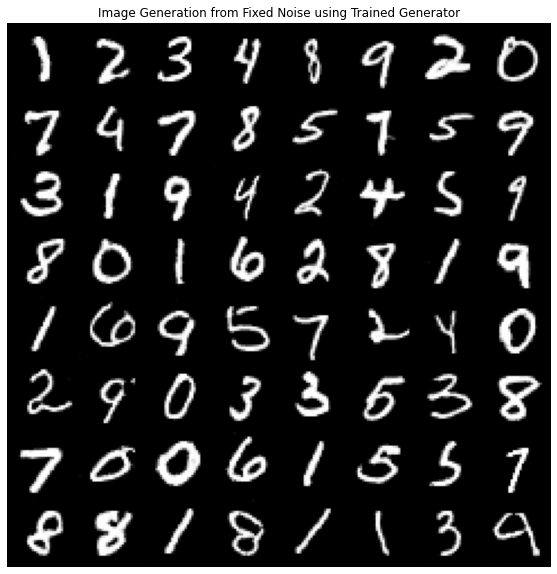

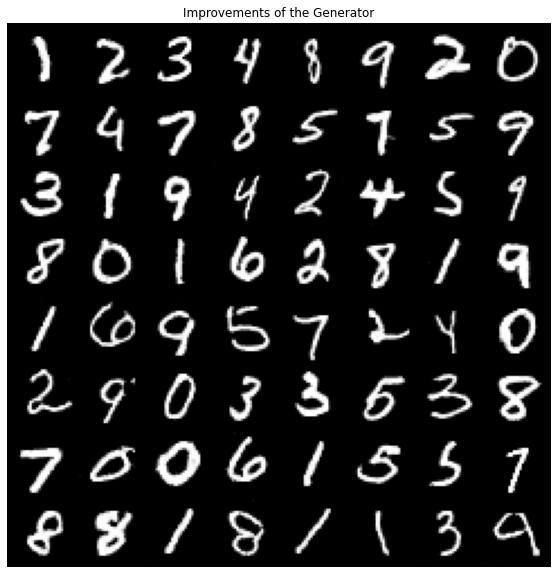

In [44]:
training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)

# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("Epoch_%d_{}".format('MNIST') %(num_epochs))
plt.title("Image Generation from Fixed Noise using Trained Generator")


# Save final network weights.
os.makedirs('checkpoint', exist_ok=True)
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    }, 'checkpoint/model_final_{}'.format('MNIST'))

# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('infoGAN_{}.gif'.format('MNIST'), dpi=80, writer='pillow')
plt.title("Improvements of the Generator")
plt.show()

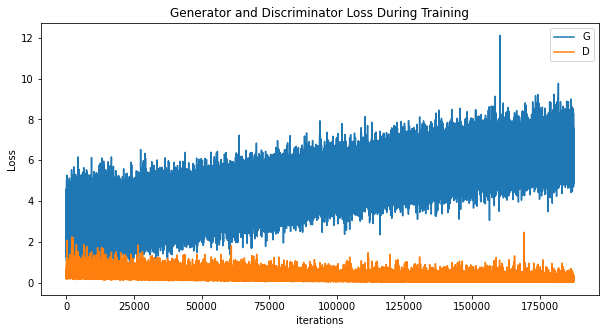

In [38]:
# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss Curve {}".format('MNIST'))

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(74, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


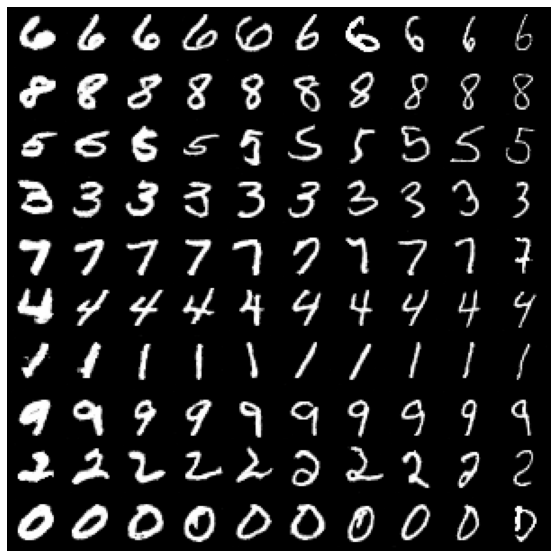

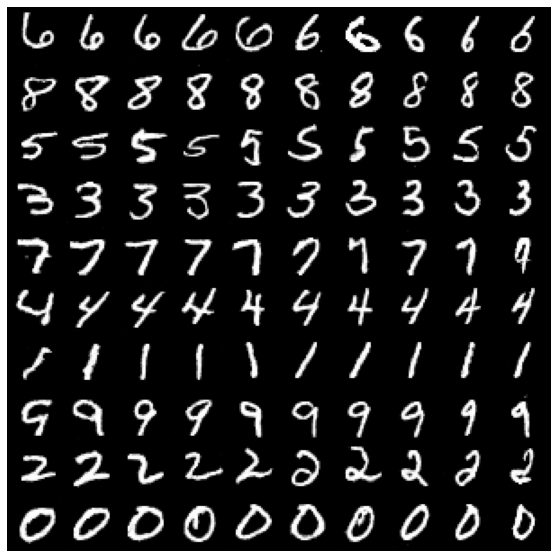

In [42]:
# Image Generation

# Load the checkpoint file
load_path = 'checkpoint/model_final_{}'.format('MNIST')
state_dict = torch.load(load_path)

# Set the device to run on: GPU or CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")

# Create the generator network.
netG = Generator().to(device)
# Load the trained generator weights.
netG.load_state_dict(state_dict['netG'])
print(netG)

c = np.linspace(-2, 2, 10).reshape(1, -1)
c = np.repeat(c, 10, 0).reshape(-1, 1)
c = torch.from_numpy(c).float().to(device)
c = c.view(-1, 1, 1, 1)

zeros = torch.zeros(100, 1, 1, 1, device=device)

# Continuous latent code.
c2 = torch.cat((c, zeros), dim=1)
c3 = torch.cat((zeros, c), dim=1)

idx = np.arange(10).repeat(10)
dis_c = torch.zeros(100, 10, 1, 1, device=device)
dis_c[torch.arange(0, 100), idx] = 1.0
# Discrete latent code.
c1 = dis_c.view(100, -1, 1, 1)

z = torch.randn(100, 62, 1, 1, device=device)

# To see variation along c2 (Horizontally) and c1 (Vertically)
noise1 = torch.cat((z, c1, c2), dim=1)
# To see variation along c3 (Horizontally) and c1 (Vertically)
noise2 = torch.cat((z, c1, c3), dim=1)

# Generate image.
with torch.no_grad():
    generated_img1 = netG(noise1).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img1, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()

# Generate image.
with torch.no_grad():
    generated_img2 = netG(noise2).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img2, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()

# 결과 해석
- Loss plot을 보면 discriminator의 loss가 빠르게 0으로 수렴하고 generator의 loss가 발산하는 것을 확인할 수 있습니다. 이는 학습이 discriminator 에 overfitting 되었기때문에(discriminator의 학습이 generator의 학습보다 더 쉽기때문에) 발생하는 문제로 보이며, 이후에는 generator가 만드는 이미지들이 discriminator를 속이지 못하는 것을 의미합니다.   
(이 문제에 대한 해결방안으로는 discriminator의 input image에 gaussian noise를 추가하여 $n/255$ 형태의 이미지를 맞추는것보다 더 어렵게 만드는 방법이 있습니다.)  


- 최종 셀에 있는 MNIST Image grid를 보면, 첫번째 grid는 열로는 숫자가 달라지는 것을, 행으로는 글자의 굵기가 달라지는 것을 확인할수 있으며, 두번째 grid는 열로는 숫자가 달라지는 것을, 행으로는 글자의 기울기가 달라지는 것을 확인할 수 있습니다. 이를 통해서 우리가 학습한 code가 interpolation을 따라서 해석이 가능한 disentangle 되어 있는 특징들임을 확인할 수 있습니다.